# Stream Power Law with Numba

### 🌊 What you'll see
- ⚙️ D8 steepest-descent routing using `@njit`.
- 🧮 Flow accumulation (drainage area) in a fully compiled loop.
- 🪨 Implicit stream power integration (Braun & Willett, 2013 style) via Newton iterations.
- 🏔️ Uplift + erosion shaping a synthetic landscape over time.

## Setup


In [1]:
!pip install numba

DEPRECATION: Loading egg at /home/bgailleton/miniforge3/envs/scb/lib/python3.11/site-packages/flow_cuda-0.0.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/bgailleton/miniforge3/envs/scb/lib/python3.11/site-packages/daggerpy-0.0.17-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

plt.rcParams['figure.figsize'] = (6, 5)
np.random.seed(10)


### 📐 Model parameters
Everything here mirrors classic stream-power notation: `K`, `m`, `n`, uplift rate, and timestep. Tweak them to explore different tectonic or climatic regimes.


In [ ]:
ncolumns, nrows = 180, 180
cell_size = 50.0  # metres
pixel_area = cell_size * cell_size

# Stream power parameters (Braun & Willett style)
K = 2.5e-5
m = 0.5
n = 1.0
uplift_rate = 5e-4  # m/yr
time_step = 1e4  # years
n_steps = 1000

init_relief = 200.0
noise_amplitude = 10.0

### 🏞️ Initial topography
A synthetic plateau with tilt and noise gives the droplets somewhere interesting to carve—feel free to replace this with DEM data.


In [ ]:
x = np.linspace(-1, 1, ncolumns)
y = np.linspace(-1, 1, nrows)
X, Y = np.meshgrid(x, y, indexing='ij')

# Baseline uplifted plateau with a gentle tilt
z0 = init_relief * np.exp(-2.5 * (X**2 + (Y + 0.3)**2))
z0 += 40.0 * X
z0 += 20.0 * Y
z0 += noise_amplitude * np.random.randn(ncolumns, nrows)
z0 -= z0.min()

elevation = z0.copy()

plt.figure(figsize=(6, 5))
plt.imshow(z0.T, origin='lower', cmap='terrain')
plt.title('Initial elevation (m)')
plt.colorbar(label='m')
plt.xticks([])
plt.yticks([])
plt.show()

### 🧠 Numba kernels
Receivers, accumulation, and the implicit solver are all compiled helpers. The comments guide you through how each piece maps onto Braun & Willett (2013).


In [ ]:
@njit(cache=True)
def compute_receivers(elev, cell_size):
    nrows, ncolumns = elev.shape
    n = nrows * ncolumns
    receivers = np.full(n, -1, np.int64)
    slope = np.zeros(n, np.float64)
    dist2rec = np.zeros(n, np.float64)
    
    for ix in range(nrows):
        for iy in range(ncolumns):
            idx = ix * ncolumns + iy
            z_here = elev[ix, iy]
            steepest = 0.0
            best = idx
            for dx in (-1, 0, 1):
                for dy in (-1, 0, 1):
                    if dx == 0 and dy == 0:
                        continue
                    row = ix + dx
                    col = iy + dy
                    if row < 0 or row >= nrows or col < 0 or col >= ncolumns:
                        continue
                    dz = z_here - elev[row, col]
                    if dz <= 0.0:
                        continue
                    dist = cell_size * np.sqrt(dx * dx + dy * dy)
                    local_slope = dz / dist
                    if local_slope > steepest:
                        steepest = local_slope
                        best = row * ncolumns + col
                        dist2rec[idx] = dist
            receivers[idx] = best
            slope[idx] = steepest
    return receivers, dist2rec, slope

@njit(cache=True)
def rec2don(receivers, ndonors, donors):

    # ndonors.fill(0)
    for node in np.arange(receivers.shape[0]):
        rec = receivers[node]
        if(node == rec):
            continue
        donors[rec*8 + ndonors[rec]] = node
        ndonors[rec] += 1
    
@njit(cache=True)
def _recursive(node, stack, istack, ndonors, donors):
    stack[istack] = node
    istack += 1
    for k in range(ndonors[node]):
         _recursive(donors[node*8+k],stack,istack,ndonors,donors)

        
@njit(cache=True)
def topological_order(receivers, ndonors, donors):
    stack  = np.arange(receivers.shape[0], dtype = np.int32)
    istack = 0
    for i in range(stack.shape[0]):
        if receivers[i] == i:
           _recursive(i,stack,istack,ndonors,donors) 
    return stack
    
    

@njit(cache=True)
def accumulate_area(order, receivers, pixel_area):
    area = np.full(receivers.size, pixel_area, np.float64)
    for idx in range(order.size - 1, -1, -1):
        node = order[idx]
        rec = receivers[node]
        if rec != -1:
            area[rec] += area[node]
    return area

@njit(cache = True)
def implicit_SPIL(elevation, stack, receivers, dist2receivers,
         area, k, m, n, dt, tolerance, nnodes):
  for inode in range(nnodes):
    istack = stack[inode]
    irec = receivers[istack]
    # print(inode)

    if irec == istack:
      # no erosion at basin outlets
      continue

    factor = k * dt * area[istack]**m / dist2receivers[istack]**n

    ielevation = elevation[istack]
    irec_elevation = elevation[irec]

    # iterate: lower elevation until convergence
    elevation_k = ielevation
    elevation_prev = np.inf

    while abs(elevation_k - elevation_prev) > tolerance:
      elevation_prev = elevation_k
      slope = elevation_k - irec_elevation
      diff = ((elevation_k - ielevation + factor * (slope)**n) /
          (1. + factor * n * slope**(n - 1)))
      elevation_k -= diff

    elevation[istack] = elevation_k

@njit(cache=True)
def uplift_elev(elev,receivers, uplift, dt, nrows, ncolumns):
    for i in range(elev.shape[0]):
        col = i%ncolumns
        row = i//ncolumns
        if row == 0 or col == 0 or row == nrows-1 or col == ncolumns-1:
            continue
        if receivers[i] == i:
            elev[i] += uplift * dt
        else:
            elev[i] += 10*uplift*dt

@njit(cache=True)
def update_landscape(elev, dt, K, m, n, uplift, cell_size):
    receivers, dist2receivers, slope = compute_receivers(elev, cell_size)
    ndonors = np.zeros(elev.shape[0]*elev.shape[1], dtype = np.int32)
    donors = np.zeros(elev.shape[0]*elev.shape[1]*8, dtype = np.int32)
    rec2don(receivers, ndonors, donors)
    order = topological_order(receivers, ndonors, donors)
    area = accumulate_area(order, receivers, cell_size * cell_size)
    uplift_elev(elev.ravel(), receivers, uplift, dt, elev.shape[0], elev.shape[1])
    implicit_SPIL(elev.ravel(), order, receivers, dist2receivers, area.ravel(), K, m, n, dt, 1e-4, elev.shape[0]*elev.shape[1])
    # elev += uplift*dt
    
    return elev, receivers, slope, area, relief

### ▶️ Run the simulation
Advance the landscape through time and store relief/mean height so you can plot trends later. Edge clamping keeps the base level grounded.


In [ ]:
# elevation = z0.copy()
relief_history = []
mean_height = []
area = np.full(ncolumns * nrows, pixel_area)

for step in range(n_steps):
    elevation, receivers, slope, area, relief = update_landscape(
        elevation, time_step, K, m, n, uplift_rate, cell_size
    )
    relief_history.append(relief)
    mean_height.append(elevation.mean())

    # soft edge condition: clamp base level at border
    base = elevation.min()
    elevation[0, :] = base
    elevation[-1, :] = base
    elevation[:, 0] = base
    elevation[:, -1] = base

### 🖼️ Visualise final state
Side-by-side plots make it easy to compare initial vs. final relief, plus the net change field to highlight channel incision.


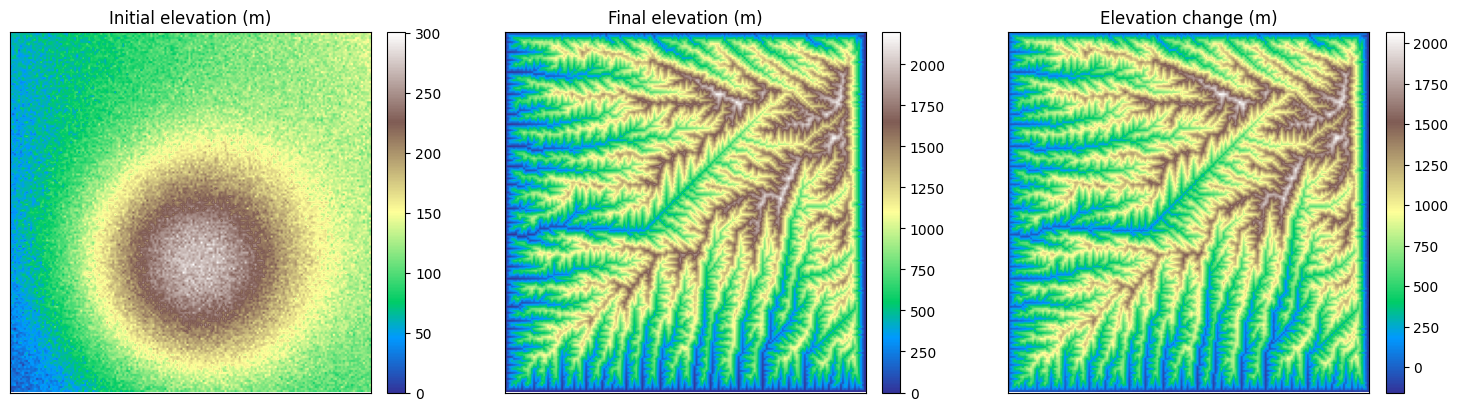

In [102]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
imgs = [
    (z0.T, 'Initial elevation (m)'),
    (elevation.T, 'Final elevation (m)'),
    ((elevation - z0).T, 'Elevation change (m)')
]
for ax, (data, title) in zip(axes, imgs):
    im = ax.imshow(data, origin='lower', cmap='terrain')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.show()


### 📈 Diagnostics
Simple time-series plots reveal whether the model is equilibrating or still transients—great for sanity-checking parameter tweaks.


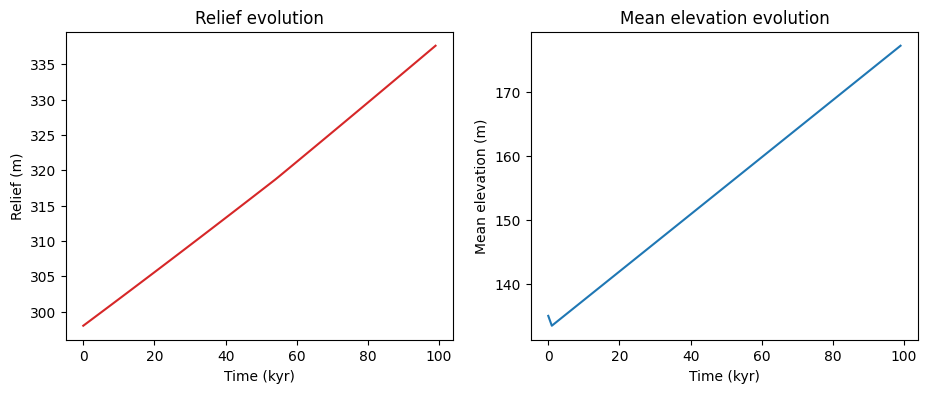

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
ax[0].plot(np.arange(n_steps) * time_step / 1_000, relief_history, color='tab:red')
ax[0].set_xlabel('Time (kyr)')
ax[0].set_ylabel('Relief (m)')
ax[0].set_title('Relief evolution')

ax[1].plot(np.arange(n_steps) * time_step / 1_000, mean_height, color='tab:blue')
ax[1].set_xlabel('Time (kyr)')
ax[1].set_ylabel('Mean elevation (m)')
ax[1].set_title('Mean elevation evolution')
plt.show()


### 🧭 Flow routing sanity check
Always eyeball drainage area: a log-scaled map quickly exposes disconnected basins or routing bugs.


In [ ]:
drainage_area = area.reshape(ncolumns, nrows)
plt.figure(figsize=(6, 5))
plt.imshow(np.log10(drainage_area.T + 1), origin='lower', cmap='viridis')
plt.title('log10 drainage area (m²)')
plt.colorbar(label='log₁₀(A)')
plt.xticks([])
plt.yticks([])
plt.show()